# ISS Location Forecast

### A time series of surface coordinates for the International Space Station (ISS) has been provided and we want to create a model that it will be able to predict ISS's location at a given datetime: 10/09/2019 @ 12:10:00. The data available consist of 145 observations during a full day from 08/09/2019 to 09/09/2019 with a 10-minute frequency and 2 geospatial variables: Latitude and Longitude.
### These two variables represent a point in the 2dimensional map of Earth, they are not independent from one another, thus making our problem a Multivariate Time Series one. We will use Vector Autoregression (VAR) which is a multivariate forecasting algorithm that is used when two or more time series influence each other.


## Contents

```
1. Used libraries import
2. Dataset loading
3. Time Series visualization
4. Causation test
5. Cointegration test
6. Training and Testing Dataset split
7. Stationarity Test
8. Var Order (range) Selection
9. Lag parameter tuning on test dataset 
   Fit model - Forecast - Evaluate
10.Final Model Train and Save
11.Final Forecast
12.Final Evaluation and Points to be seen in the future
```

## 1. Install and Import Used libraries

In [5]:
!pip install numpy
!pip install pandas 
!pip install matplotlib
!pip install statsmodels

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

## 2. Dataset loading

In [38]:
import os

# Import our dataset
df = pd.read_csv("../data/data.csv", parse_dates=['Time'])
print(df.dtypes)
print(df.shape)
# Set time as index
df.index = df.Time
df = df.drop(['Time'], axis=1)
df

Time         datetime64[ns, UTC]
Latitude                 float64
Longitude                float64
dtype: object
(144, 3)


,Latitude,Longitude
Time,,
2019-09-08 00:10:00+00:00,-43.025,-9.414
2019-09-08 00:20:00+00:00,-17.103,155.199
2019-09-08 00:30:00+00:00,-43.252,-173.599
2019-09-08 00:40:00+00:00,-50.867,-119.158
2019-09-08 00:50:00+00:00,-31.793,-75.629
...,...,...
2019-09-08 23:20:00+00:00,19.847,133.991
2019-09-08 23:30:00+00:00,-10.403,156.257
2019-09-08 23:40:00+00:00,-38.284,-176.195


## 3. Time Series visualization

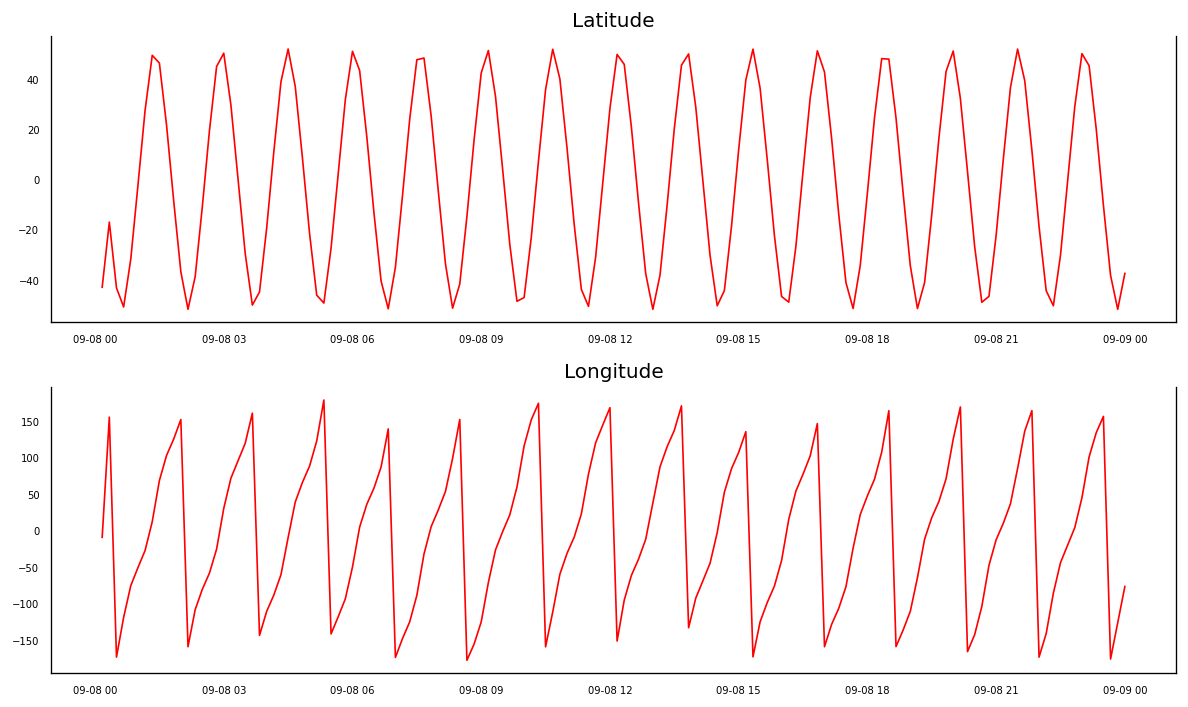

In [39]:
# Visualize the time series
fig, axes = plt.subplots(nrows=2, ncols=1, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

#### The ISS circles the Earth in roughly 93 minutes, completing 15.5 orbits per day, so the above diagrams are what exactly we expected with 15,5 cycles for both Latitude and Longitude from the beginning to the end of the day (2019-09-08 - 2019-09-09). 

## 4. Causation test

### Testing Causation using Granger’s Causality Test, does each of the time series in the system influence each other?

In [40]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=24
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)     

,Latitude_x,Longitude_x
Latitude_y,1.0000,0.0
Longitude_y,0.0012,1.0


####  The p-values obtained from the test are lesser than the significance level of 0.05 for both variables, so we can safely say that both time series influence each other.


## 5. Cointegration Test

In [41]:
# Cointegration test helps to establish the presence
# of a statistically significant connection between our time series.
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Latitude ::  490.1     > 12.3212   =>   True
Longitude ::  80.29     > 4.1296    =>   True


## 6. Training and Testing Dataset split

#### The dataset consists of 145 observations of one day (2019-09-08 to 2019-09-09) with a 10-minute frequency.
#### The ISS circles the Earth in roughly 93 minutes, completing 15.5 orbits per day (as mentioned above). So, we will choose our testing dataset to be of size 15, thus we will try to predict a day's and a half period for its locations.


In [44]:
observations = 15
df_train, df_test = df[:-observations], df[-observations:]

# Check size
print(df_train.shape)
print(df_test.shape)

(129, 2)
(15, 2)


## 7. Stationarity Test

In [45]:
# The VAR model requires the time series we want to forecast to be stationary, so it is customary to check
# all the time series in the system for stationarity (characteristics like mean and variance does not change over time)
# Augmented Dickey Fuller test (ADF Test) is a common statistical test used to test whether a given Time series 
# is stationary or not. It is one of the most commonly used statistical test when it comes to analyzing the
# stationary of a series.

def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")   

In [46]:
# ADF Test on each column
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Latitude" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.27
 No. Lags Chosen       = 12
 Critical value 1%     = -3.488
 Critical value 5%     = -2.887
 Critical value 10%    = -2.58
 => P-Value = 0.6428. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Longitude" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.1592
 No. Lags Chosen       = 9
 Critical value 1%     = -3.487
 Critical value 5%     = -2.886
 Critical value 10%    = -2.58
 => P-Value = 0.2214. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.




#### The ADF test confirms that none of the time series is stationary. We will difference them and test again.

In [48]:
df_differenced = df_train.diff().dropna()

# ADF Test on each column of the Differenced Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Latitude" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.6552
 No. Lags Chosen       = 12
 Critical value 1%     = -3.489
 Critical value 5%     = -2.887
 Critical value 10%    = -2.58
 => P-Value = 0.0001. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Longitude" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -20.263
 No. Lags Chosen       = 8
 Critical value 1%     = -3.487
 Critical value 5%     = -2.886
 Critical value 10%    = -2.58
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.




#### As we can see the p-values for both variables are zero now and both time series became stationary.

## 8. Var Order Selection

/Users/manolis/anaconda3/envs/trg/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  % freq, ValueWarning)


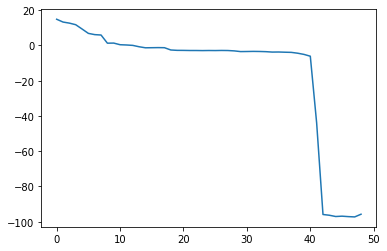

In [15]:
# To select the right order of the VAR model, we iteratively fit increasing orders
# of VAR model and pick the order that gives a model with least AIC.

model = VAR(df_differenced)
aic_results = list()
for i in range(1, 50):
    result = model.fit(i)
    aic_results.append(result.aic)

plt.plot(aic_results)
plt.show()

#### We tested AIC performance metric for 50 lags. We can see that AIC drops to the first lowest at lag ~12, then it stabilizes for ~20 lags and then it drops sharply. We will choose lag number in range of 10-30 by testing their performance on the test dataset.

## 9. Lag parameter tuning on test dataset 
###   Fit model - Forecast - Evaluate
#### Evaluation will performed on 
* Mean Absolute Error Metric
* Serial Correlation of Residuals (Errors) using Durbin Watson Statistic

In [49]:
def invert_transformation(df_train, df_forecast):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    df_tr = df_train.copy()
    columns = df_tr.columns
    for col in columns:        
        df_fc[str(col)+'_forecast'] = df_tr[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc


from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mae = np.mean(np.abs(forecast - actual))
    return mae


from statsmodels.stats.stattools import durbin_watson
'''
If there is any correlation left in the residuals, then, there is some pattern in the time series that is still left
to be explained by the model.
The value of this statistic can vary between 0 and 4. The closer it is to the value 2, then there is no significant
serial correlation. The closer to 0, there is a positive serial correlation, and the closer it is to 4 implies 
negative serial correlation.
'''

def compare_results_on_test_dataset(train_df, test_df, input_model, lag_order, nobs):
    model_fitted = input_model.fit(lag_order)
    forecast_input = train_df.values[-lag_order:]
    # Forecast
    fc = model_fitted.forecast(y=forecast_input, steps=nobs)
    df_forecast = pd.DataFrame(fc, index=train_df.index[-nobs:], columns=train_df.columns + '_1d')
    df_results = invert_transformation(train_df, df_forecast)
    mae = forecast_accuracy(df_results['Latitude_forecast'].values, test_df['Latitude'])
    print('Latitude: Mean Absolute Error:', round(mae, 3))
    mae = forecast_accuracy(df_results['Longitude_forecast'].values, test_df['Longitude'])
    print('Longitude: Mean Absolute Error:', round(mae, 3))
    durbin_watson_results = durbin_watson(model_fitted.resid)
    print(durbin_watson_results)

In [50]:
model = VAR(df_differenced)
# Test models' performance for lag number (10-31)
for i in range(10, 31):
    print('Lag Order:', i)
    compare_results_on_test_dataset(df_differenced, df_test, model, i, observations)
    print()

Lag Order: 10
Latitude: Mean Absolute Error: 36.363
Longitude: Mean Absolute Error: 46.715
[1.99888932 1.97394554]

Lag Order: 11
Latitude: Mean Absolute Error: 36.368
Longitude: Mean Absolute Error: 45.177
[2.6462812  1.99090019]

Lag Order: 12
Latitude: Mean Absolute Error: 36.37
Longitude: Mean Absolute Error: 45.217
[1.50980936 2.00845409]

Lag Order: 13
Latitude: Mean Absolute Error: 36.368
Longitude: Mean Absolute Error: 42.785
[2.76178985 2.02583937]

Lag Order: 14
Latitude: Mean Absolute Error: 36.365
Longitude: Mean Absolute Error: 37.214
[0.96180511 1.99861883]

Lag Order: 15
Latitude: Mean Absolute Error: 36.37
Longitude: Mean Absolute Error: 41.7
[1.72815954 1.99525865]

Lag Order: 16
Latitude: Mean Absolute Error: 36.368
Longitude: Mean Absolute Error: 38.646
[1.97291276 1.97978716]

Lag Order: 17
Latitude: Mean Absolute Error: 36.369
Longitude: Mean Absolute Error: 40.48
[1.94607284 2.03490447]

Lag Order: 18
Latitude: Mean Absolute Error: 36.367
Longitude: Mean Absolute 

/Users/manolis/anaconda3/envs/trg/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  % freq, ValueWarning)


#### We can see that Latitude's Mean Absolute Error stays the same for all lag orders (~36.3) and Longitude's MAE is the best for Lag Order: 16
#### We also observe that durbin_watson statistics diverge from value 2 at most lag orders. That means that some pattern in the time series is still left to be explained by the model.
#### On the other hand, for lag number 16 the durbin_watson statistics are close to 2 which is the best possible.


### So, we will keep Lag Order 16 and fit our final model with all the dataset included, in order to forecast for the next 2 days 09/09 and 10/09 (our wanted prediction date is 10/09/2019 @ 12:10:00)

In [18]:
LAG_ORDER = 16

## 10. Final Model Train and Save

In [51]:
df = pd.read_csv("../data/data.csv", parse_dates=['Time'])
df.index = df.Time
df = df.drop(['Time'], axis=1)

# ADF Test
for name, column in df.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Latitude" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.5648
 No. Lags Chosen       = 13
 Critical value 1%     = -3.482
 Critical value 5%     = -2.884
 Critical value 10%    = -2.579
 => P-Value = 0.1005. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Longitude" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.2914
 No. Lags Chosen       = 9
 Critical value 1%     = -3.48
 Critical value 5%     = -2.883
 Critical value 10%    = -2.578
 => P-Value = 0.1748. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.




#### Differentiate them to make the time series stationary

In [52]:
final_df_differenced = df.diff().dropna()

# ADF Test on each column of the Differenced Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Latitude" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.6552
 No. Lags Chosen       = 12
 Critical value 1%     = -3.489
 Critical value 5%     = -2.887
 Critical value 10%    = -2.58
 => P-Value = 0.0001. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Longitude" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -20.263
 No. Lags Chosen       = 8
 Critical value 1%     = -3.487
 Critical value 5%     = -2.886
 Critical value 10%    = -2.58
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.




In [21]:
# Durbin Watson test on final model

final_model = VAR(final_df_differenced)
final_model_fitted = final_model.fit(LAG_ORDER)
durbin_watson_results = durbin_watson(final_model_fitted.resid)
print(durbin_watson_results)


[1.97951086 1.97080855]


/Users/manolis/anaconda3/envs/trg/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  % freq, ValueWarning)


#### Durbin Watson Statistics' Results are almost 2 ,which is the best result possible, for both variables.

### Save model

In [22]:
final_model_fitted.save('final_var_model.pkl')

## 11. Final Forecast

### We want to forecast the next 2 days (last forecast datetime in our data is 2019-09-09T00:00) to include the required date: 10/09/2019 @ 12:10:00.

In [23]:
# forecast_observations for next 2 days with 10minute frequency
FORECAST_OBSERVATIONS = 287
final_forecast_input = final_df_differenced.values[-LAG_ORDER:]
final_fc = final_model_fitted.forecast(y=final_forecast_input, steps=FORECAST_OBSERVATIONS)

print("Final Forecast's length:", len(final_fc))

Final Forecast's length: 287


#### Create new dataframe for the forecast to include the required date: 10/09/2019 @ 12:10:00.

In [54]:
input_df = pd.DataFrame(
        {'Time': pd.date_range('2019-09-09', '2019-09-11', freq='10min', closed='left')}
     )
input_df.index = input_df.Time
input_df = input_df.drop(['Time'], axis=1)
# Delete first row with datetime 2019-09-09 00:00:00 as it is the last row of our dataset
input_df = input_df.iloc[1:]
len(input_df)

287

In [55]:
final_forecast_df = pd.DataFrame(final_fc, index=input_df.index, columns=df.columns + '_1d')
final_results = invert_transformation(df, final_forecast_df)

# We will keep the first 220 results
final_results = final_results[:220]

In [56]:
latitude_forecast = final_results['Latitude_forecast'].tolist()
longitude_forecast = final_results['Longitude_forecast'].tolist()

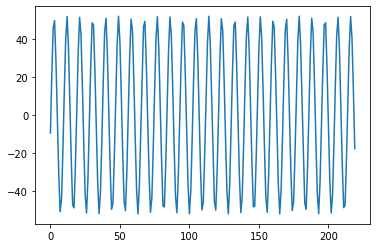

In [27]:
plt.plot(latitude_forecast)
plt.show()

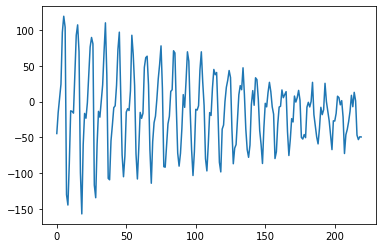

In [57]:
plt.plot(longitude_forecast)
plt.show()

## 12. Final Evaluation and Points to be seen in the future

### Latitude forecast resembles a lot training dataset's latitude plot. However, Longitude's plot shows a clear variance convergence as long as the observations progress. That is something our model does not explain and we should look in the future.

### After testing our predictions we observed that our forecast at its last 50 predictions implies a change in ISS's orbit, meaning that the longitude points some times go from east to west which is wrong.

### For the first predictions our model seems to perform well. That is not the case as the observations continue. That is a serious issue for our model due to the fact that the required datetime we want to predict is almost 200 observations after the last one of our dataset. After all, our result is not expected to be accurate.

### Forecast for 2019-09-10 12:10:00

In [58]:
final_results.loc['2019-09-10 12:10:00']

Latitude_1d           16.253333
Longitude_1d         -47.705239
Latitude_forecast     51.613412
Longitude_forecast   -46.644147
Name: 2019-09-10 12:10:00, dtype: float64

### The predicted location is in North Atlantic Ocean. The right location was south of South Africa.
http://www.isstracker.com/historical